In [1]:
import os
from datetime import datetime, timedelta

#import paho.mqtt.client as mqtt
import pandas as pd
# import fastparquet
import pyarrow.parquet as pq
import pyarrow
import time
data = pd.DataFrame()

ModuleNotFoundError: No module named 'paho'

In [14]:
import json

In [2]:
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("DigiMic.0.data")


In [3]:
def on_message(client, userdata, msg):
    # print(f"{msg.topic}: {msg.payload}")
    global data
    payload = msg.payload.decode()
    data= data._append({'timestamp': msg.timestamp, 'value': payload}, ignore_index=True)

In [5]:
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message
client.connect("10.1.16.189", 1883, 3600)

0

In [6]:
client.loop_start()

Connected with result code 0


In [74]:
client.loop_stop()

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423 entries, 0 to 1422
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1423 non-null   float64
 1   value      1423 non-null   object 
 2   expanded   128 non-null    object 
dtypes: float64(1), object(2)
memory usage: 33.5+ KB


In [78]:
json.loads(data.at[0,'value'])

{'WMAX0': 0.057464,
 'ZCS0': 27008,
 'RMS0': 0.013168,
 'GNDOFF0': 1.652156,
 'WMAX1': 0.021473,
 'ZCS1': 3284,
 'RMS1': 0.007365,
 'GNDOFF1': 1.65028}

In [ ]:
from matplotlib import pyplot as plt

In [80]:
# .concat(data, 
data2 = pd.concat([data[['timestamp']],data.value.apply(json.loads).apply(pd.Series)], axis=1)
# axis=0)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423 entries, 0 to 1422
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1423 non-null   float64
 1   WMAX0      1423 non-null   float64
 2   ZCS0       1423 non-null   float64
 3   RMS0       1423 non-null   float64
 4   GNDOFF0    1423 non-null   float64
 5   WMAX1      1423 non-null   float64
 6   ZCS1       1423 non-null   float64
 7   RMS1       1423 non-null   float64
 8   GNDOFF1    1423 non-null   float64
dtypes: float64(9)
memory usage: 100.2 KB


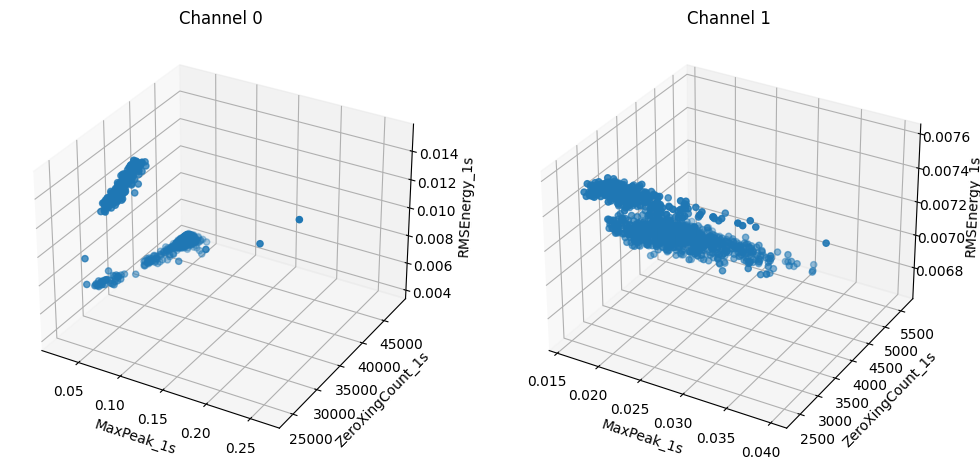

In [81]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
ax0.scatter(data2.WMAX0.values, data2.ZCS0.values, data2.RMS0.values, marker='o')
ax0.set_xlabel('MaxPeak_1s')
ax0.set_ylabel('ZeroXingCount_1s')
ax0.set_zlabel('RMSEnergy_1s')
ax0.set_title('Channel 0')
ax1.scatter(data2.WMAX1.values, data2.ZCS1.values, data2.RMS1.values, marker='o')
ax1.set_xlabel('MaxPeak_1s')
ax1.set_ylabel('ZeroXingCount_1s')
ax1.set_zlabel('RMSEnergy_1s')
ax1.set_title('Channel 1')
plt.show()

In [90]:
from sklearn.mixture import BayesianGaussianMixture as BGM

In [92]:
X = data2[[
'WMAX0',
'ZCS0',
'RMS0']].to_numpy()

In [107]:
bgm = BGM(n_components=5).fit(X)
bgm.get_params()

/usr/local/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


{'covariance_prior': None,
 'covariance_type': 'full',
 'degrees_of_freedom_prior': None,
 'init_params': 'kmeans',
 'max_iter': 100,
 'mean_precision_prior': None,
 'mean_prior': None,
 'n_components': 5,
 'n_init': 1,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weight_concentration_prior': None,
 'weight_concentration_prior_type': 'dirichlet_process'}

In [108]:
classes = bgm.predict(X)
classes

array([1, 1, 1, ..., 3, 3, 3])

In [109]:
data2['channel0_class'] = classes

In [110]:
data2.channel0_class.unique()

array([1, 2, 0, 3, 4])

In [111]:
from sklearn.cluster import DBSCAN as DBS

In [132]:
dbs = DBS(eps=.5, min_samples=3).fit(X)
data2['channel0_clusters'] = dbs.fit_predict(X)
data2.groupby('channel0_clusters').timestamp.count()

channel0_clusters
-1     1331
 0        3
 1        3
 2        3
 3        3
 4        4
 5        3
 6        3
 7        4
 8        3
 9        3
 10       3
 11       3
 12       3
 13       3
 14       3
 15       3
 16       3
 17       3
 18       4
 19       3
 20       3
 21       3
 22       3
 23       3
 24       5
 25       3
 26       3
 27       3
 28       3
Name: timestamp, dtype: int64

In [133]:
dbs.get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 3,
 'n_jobs': None,
 'p': None}

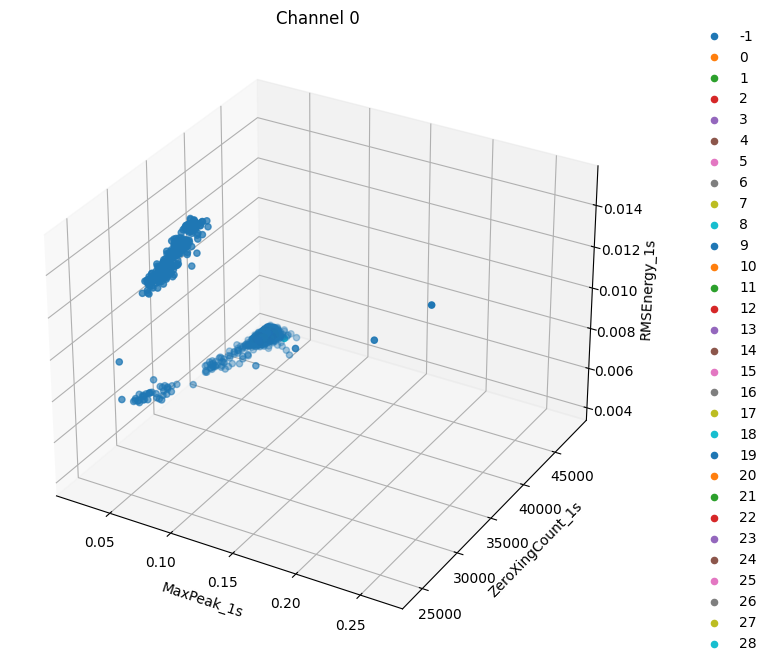

In [134]:
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(projection='3d')
for grp in data2.channel0_clusters.unique():
    ax0.scatter(data2[data2.channel0_clusters==grp].WMAX0.values, 
                data2[data2.channel0_clusters==grp].ZCS0.values, 
                data2[data2.channel0_clusters==grp].RMS0.values, 
                label=grp)

ax0.set_xlabel('MaxPeak_1s')
ax0.set_ylabel('ZeroXingCount_1s')
ax0.set_zlabel('RMSEnergy_1s')
ax0.set_title('Channel 0')
ax0.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', frameon=False)
plt.show()

In [138]:
data2

,timestamp,WMAX0,ZCS0,RMS0,GNDOFF0,WMAX1,ZCS1,RMS1,GNDOFF1,channel0_class,channel0_clusters
0,7.938505e+06,0.057464,27008.0,0.013168,1.652156,0.021473,3284.0,0.007365,1.650280,1,-1
1,7.938507e+06,0.052108,27268.0,0.013071,1.652152,0.021473,3236.0,0.007357,1.650280,1,-1
2,7.938510e+06,0.054519,27800.0,0.012989,1.652132,0.017445,3264.0,0.007344,1.650280,1,-1
3,7.938512e+06,0.060134,26493.0,0.012830,1.652136,0.019056,3174.0,0.007352,1.650280,1,-1
4,7.938514e+06,0.060126,27013.0,0.012962,1.652118,0.023890,3682.0,0.007277,1.650280,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
1418,7.941896e+06,0.027070,46077.0,0.004300,1.652094,0.017358,4508.0,0.006811,1.650366,3,-1
1419,7.941898e+06,0.026264,47195.0,0.004330,1.652094,0.022192,4722.0,0.006845,1.650366,3,-1
1420,7.941901e+06,0.029487,46944.0,0.004303,1.652095,0.023803,4508.0,0.006856,1.650367,3,12
1421,7.941903e+06,0.029326,46285.0,0.004305,1.652095,0.020580,4456.0,0.006854,1.650367,3,-1
